# EMEC 7062 GD

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sympy as sp

from IPython.display import display, Math, Latex
from scipy.integrate import cumulative_simpson, solve_ivp

In [32]:
x, y, z = sp.symbols(r'x, y, z', constant=True)

X = sp.Matrix([x, y, z])
X

Matrix([
[x],
[y],
[z]])

In [40]:
theta, phi, dtheta, dphi = sp.symbols(r'\theta, \varphi, \theta_d, \varphi_d', constant=True)
r = 1.0

R = sp.Matrix([
    sp.sqrt(X[0] ** 2 + X[1] ** 2 + X[2] ** 2),
    sp.acos(X[2] / r) + dtheta,
    sp.atan2(X[1], X[0]) + dphi,
])

R = sp.simplify(R)
R

Matrix([
[sqrt(x**2 + y**2 + z**2)],
[  \theta_d + acos(1.0*z)],
[ \varphi_d + atan2(y, x)]])

In [42]:
theta, phi, dtheta, dphi = sp.symbols(r'\theta, \varphi, \theta_d, \varphi_d', constant=True)
r = 1.0

R = sp.Matrix([
    sp.sqrt(X[0] ** 2 + X[1] ** 2 + X[2] ** 2),
    0 + dtheta,
    0 + dphi,
])

R = sp.simplify(R)
R

Matrix([
[sqrt(x**2 + y**2 + z**2)],
[                \theta_d],
[               \varphi_d]])

In [43]:
Xr = sp.Matrix([
    R[0] * sp.sin(R[1]) * sp.cos(R[2]),
    R[0] * sp.sin(R[1]) * sp.sin(R[2]),
    R[0] * sp.cos(R[1]),
])

Xr = sp.simplify(Xr)
Xr

Matrix([
[sqrt(x**2 + y**2 + z**2)*sin(\theta_d)*cos(\varphi_d)],
[sqrt(x**2 + y**2 + z**2)*sin(\theta_d)*sin(\varphi_d)],
[               sqrt(x**2 + y**2 + z**2)*cos(\theta_d)]])

 ## Model

In [2]:
# Constants
sp_half = sp.Rational(1, 2)

# Define symbols
hb, hr, hbc, eb, ew, dw = sp.symbols(r'h_b, h_r, h_bc, e_b, e_w, d_w', constant=True)
m, Ir, Iz, Iw, b, cd, rho, g = sp.symbols(r'm, I_r, I_z, I_w, b, c_d, \rho, g', constant=True)

t = sp.symbols('t')

v = sp.Function('v')(t)

r = sp.Function('r')(t)
theta = sp.Function('theta')(t)
varphi = sp.Function('varphi')(t)
psi = sp.Function('psi')(t)

r_dot = r.diff(t)
theta_dot = theta.diff(t)
varphi_dot = varphi.diff(t)
psi_dot = psi.diff(t)

r_ddot = r_dot.diff(t)
theta_ddot = theta_dot.diff(t)
varphi_ddot = varphi_dot.diff(t)
psi_ddot = psi_dot.diff(t)

### Kinematic model

#### Kinematics of the body's origin

In [3]:
Xo = sp.Function('X_o')(t)

In [4]:
Xo = sp.Matrix([
    r * sp.cos(varphi) + sp.integrate(v * sp.cos(psi), (t, 0, t)),
    r * sp.sin(varphi) + sp.integrate(v * sp.sin(psi), (t, 0, t)),
    0
])

# Output
Xo = sp.simplify(Xo)
display(Xo)

Matrix([
[r(t)*cos(varphi(t)) + Integral(v(t)*cos(psi(t)), (t, 0, t))],
[r(t)*sin(varphi(t)) + Integral(v(t)*sin(psi(t)), (t, 0, t))],
[                                                          0]])

In [5]:
Xo_dot = Xo.diff(t)

# Output
Xo_dot = sp.simplify(Xo_dot)
display(Xo_dot)

Matrix([
[-r(t)*sin(varphi(t))*Derivative(varphi(t), t) + v(t)*cos(psi(t)) + cos(varphi(t))*Derivative(r(t), t)],
[ r(t)*cos(varphi(t))*Derivative(varphi(t), t) + v(t)*sin(psi(t)) + sin(varphi(t))*Derivative(r(t), t)],
[                                                                                                    0]])

#### Kinematics of the body's left wheel

In [6]:
Xl = sp.Function('X_l')(t)

In [7]:
Xl = Xo + sp.rot_givens(1, 0, psi) * sp.Matrix([0, eb, 0])

# Output
Xl = sp.simplify(Xl)
display(Xl)

Matrix([
[-e_b*sin(psi(t)) + r(t)*cos(varphi(t)) + Integral(v(t)*cos(psi(t)), (t, 0, t))],
[ e_b*cos(psi(t)) + r(t)*sin(varphi(t)) + Integral(v(t)*sin(psi(t)), (t, 0, t))],
[                                                                             0]])

In [8]:
Xl_dot = Xl.diff(t)

# Output
Xl_dot = sp.simplify(Xl_dot)
display(Xl_dot)

Matrix([
[-e_b*cos(psi(t))*Derivative(psi(t), t) - r(t)*sin(varphi(t))*Derivative(varphi(t), t) + v(t)*cos(psi(t)) + cos(varphi(t))*Derivative(r(t), t)],
[-e_b*sin(psi(t))*Derivative(psi(t), t) + r(t)*cos(varphi(t))*Derivative(varphi(t), t) + v(t)*sin(psi(t)) + sin(varphi(t))*Derivative(r(t), t)],
[                                                                                                                                            0]])

In [9]:
Xl_dot_norm = sp.sqrt(Xl_dot.dot(Xl_dot))

# Output
Xl_dot_norm = sp.simplify(Xl_dot_norm)
display(Xl_dot_norm)

sqrt(e_b**2*Derivative(psi(t), t)**2 - 2*e_b*r(t)*sin(psi(t) - varphi(t))*Derivative(psi(t), t)*Derivative(varphi(t), t) - 2*e_b*v(t)*Derivative(psi(t), t) - 2*e_b*cos(psi(t) - varphi(t))*Derivative(psi(t), t)*Derivative(r(t), t) + r(t)**2*Derivative(varphi(t), t)**2 + 2*r(t)*v(t)*sin(psi(t) - varphi(t))*Derivative(varphi(t), t) + v(t)**2 + 2*v(t)*cos(psi(t) - varphi(t))*Derivative(r(t), t) + Derivative(r(t), t)**2)

In [10]:
omega_l = 2 * Xl_dot_norm / dw

# Output
omega_l = sp.simplify(omega_l)
display(omega_l)

2*sqrt(e_b**2*Derivative(psi(t), t)**2 - 2*e_b*r(t)*sin(psi(t) - varphi(t))*Derivative(psi(t), t)*Derivative(varphi(t), t) - 2*e_b*v(t)*Derivative(psi(t), t) - 2*e_b*cos(psi(t) - varphi(t))*Derivative(psi(t), t)*Derivative(r(t), t) + r(t)**2*Derivative(varphi(t), t)**2 + 2*r(t)*v(t)*sin(psi(t) - varphi(t))*Derivative(varphi(t), t) + v(t)**2 + 2*v(t)*cos(psi(t) - varphi(t))*Derivative(r(t), t) + Derivative(r(t), t)**2)/d_w

#### Kinematics of the body's right wheel

In [11]:
Xr = sp.Function('X_r')(t)

In [12]:
Xr = Xo + sp.rot_givens(1, 0, psi) * sp.Matrix([0, -eb, 0])

# Output
Xr = sp.simplify(Xr)
display(Xr)

Matrix([
[ e_b*sin(psi(t)) + r(t)*cos(varphi(t)) + Integral(v(t)*cos(psi(t)), (t, 0, t))],
[-e_b*cos(psi(t)) + r(t)*sin(varphi(t)) + Integral(v(t)*sin(psi(t)), (t, 0, t))],
[                                                                             0]])

In [13]:
Xr_dot = Xr.diff(t)

# Output
Xr_dot = sp.simplify(Xr_dot)
display(Xr_dot)

Matrix([
[e_b*cos(psi(t))*Derivative(psi(t), t) - r(t)*sin(varphi(t))*Derivative(varphi(t), t) + v(t)*cos(psi(t)) + cos(varphi(t))*Derivative(r(t), t)],
[e_b*sin(psi(t))*Derivative(psi(t), t) + r(t)*cos(varphi(t))*Derivative(varphi(t), t) + v(t)*sin(psi(t)) + sin(varphi(t))*Derivative(r(t), t)],
[                                                                                                                                           0]])

In [14]:
Xr_dot_norm = sp.sqrt(Xr_dot.dot(Xr_dot))

# Output
Xr_dot_norm = sp.simplify(Xr_dot_norm)
display(Xr_dot_norm)

sqrt(e_b**2*Derivative(psi(t), t)**2 + 2*e_b*r(t)*sin(psi(t) - varphi(t))*Derivative(psi(t), t)*Derivative(varphi(t), t) + 2*e_b*v(t)*Derivative(psi(t), t) + 2*e_b*cos(psi(t) - varphi(t))*Derivative(psi(t), t)*Derivative(r(t), t) + r(t)**2*Derivative(varphi(t), t)**2 + 2*r(t)*v(t)*sin(psi(t) - varphi(t))*Derivative(varphi(t), t) + v(t)**2 + 2*v(t)*cos(psi(t) - varphi(t))*Derivative(r(t), t) + Derivative(r(t), t)**2)

In [15]:
omega_r = 2 * Xr_dot_norm / dw

# Output
omega_r = sp.simplify(omega_r)
display(omega_r)

2*sqrt(e_b**2*Derivative(psi(t), t)**2 + 2*e_b*r(t)*sin(psi(t) - varphi(t))*Derivative(psi(t), t)*Derivative(varphi(t), t) + 2*e_b*v(t)*Derivative(psi(t), t) + 2*e_b*cos(psi(t) - varphi(t))*Derivative(psi(t), t)*Derivative(r(t), t) + r(t)**2*Derivative(varphi(t), t)**2 + 2*r(t)*v(t)*sin(psi(t) - varphi(t))*Derivative(varphi(t), t) + v(t)**2 + 2*v(t)*cos(psi(t) - varphi(t))*Derivative(r(t), t) + Derivative(r(t), t)**2)/d_w

#### Kinematics of the body's center of mass

In [16]:
Xco = sp.Function('X_c')(t)
Xc = sp.Function('X_c')(t)

In [17]:
# Xco = sp.Matrix([
#     hbc * sp.sin(theta) * sp.cos(psi),
#     hbc * sp.sin(theta) * sp.sin(psi),
#     hbc * sp.cos(theta)
# ])

Xco = sp.rot_givens(1, 0, psi) * sp.rot_givens(2, 0, theta) * sp.Matrix([0, 0, hbc])

Xc = Xo + Xco

# Output
Xc = sp.simplify(Xc)
display(Xc)

Matrix([
[-h_bc*sin(theta(t))*cos(psi(t)) + r(t)*cos(varphi(t)) + Integral(v(t)*cos(psi(t)), (t, 0, t))],
[-h_bc*sin(psi(t))*sin(theta(t)) + r(t)*sin(varphi(t)) + Integral(v(t)*sin(psi(t)), (t, 0, t))],
[                                                                           h_bc*cos(theta(t))]])

In [18]:
# Xc_dot = Xo_dot + Xco.diff(t)

omegao = sp.Matrix([
    0,
    theta_dot,
    psi_dot,
])

omegac = sp.rot_givens(1, 0, psi) * sp.rot_givens(2, 0, theta) * omegao
Xc_dot = Xo_dot + omegac.cross(Xco)

# Output
Xc_dot = sp.simplify(Xc_dot)
display(Xc_dot)

Matrix([
[h_bc*cos(psi(t))*cos(theta(t))*Derivative(theta(t), t) - r(t)*sin(varphi(t))*Derivative(varphi(t), t) + v(t)*cos(psi(t)) + cos(varphi(t))*Derivative(r(t), t)],
[h_bc*sin(psi(t))*cos(theta(t))*Derivative(theta(t), t) + r(t)*cos(varphi(t))*Derivative(varphi(t), t) + v(t)*sin(psi(t)) + sin(varphi(t))*Derivative(r(t), t)],
[                                                                                                                   h_bc*sin(theta(t))*Derivative(theta(t), t)]])

In [19]:
Xc_dot_norm = sp.sqrt(Xc_dot.dot(Xc_dot))

# Output
Xc_dot_norm = sp.simplify(Xc_dot_norm)
display(Xc_dot_norm)

sqrt(h_bc**2*Derivative(theta(t), t)**2 + 2*h_bc*r(t)*sin(psi(t) - varphi(t))*cos(theta(t))*Derivative(theta(t), t)*Derivative(varphi(t), t) + 2*h_bc*v(t)*cos(theta(t))*Derivative(theta(t), t) + 2*h_bc*cos(psi(t) - varphi(t))*cos(theta(t))*Derivative(r(t), t)*Derivative(theta(t), t) + r(t)**2*Derivative(varphi(t), t)**2 + 2*r(t)*v(t)*sin(psi(t) - varphi(t))*Derivative(varphi(t), t) + v(t)**2 + 2*v(t)*cos(psi(t) - varphi(t))*Derivative(r(t), t) + Derivative(r(t), t)**2)

### Dynamic model

#### Kinect energy of the body

In [20]:
T = (
        sp_half * m * Xc_dot_norm ** 2
        + sp_half * Ir * theta_dot ** 2
        + sp_half * Iz * psi_dot ** 2
        # + sp_half * (Iz + m * (hbc * sp.sin(theta)) ** 2) * psi_dot ** 2
        + sp_half * Iw * (omega_l ** 2 + omega_r ** 2)
)

# Output
T = sp.simplify(T)
display(T)

(8*I_w*(e_b**2*Derivative(psi(t), t)**2 + r(t)**2*Derivative(varphi(t), t)**2 + 2*r(t)*v(t)*sin(psi(t) - varphi(t))*Derivative(varphi(t), t) + v(t)**2 + 2*v(t)*cos(psi(t) - varphi(t))*Derivative(r(t), t) + Derivative(r(t), t)**2) + d_w**2*(I_r*Derivative(theta(t), t)**2 + I_z*Derivative(psi(t), t)**2 + m*(h_bc**2*Derivative(theta(t), t)**2 + 2*h_bc*r(t)*sin(psi(t) - varphi(t))*cos(theta(t))*Derivative(theta(t), t)*Derivative(varphi(t), t) + 2*h_bc*v(t)*cos(theta(t))*Derivative(theta(t), t) + 2*h_bc*cos(psi(t) - varphi(t))*cos(theta(t))*Derivative(r(t), t)*Derivative(theta(t), t) + r(t)**2*Derivative(varphi(t), t)**2 + 2*r(t)*v(t)*sin(psi(t) - varphi(t))*Derivative(varphi(t), t) + v(t)**2 + 2*v(t)*cos(psi(t) - varphi(t))*Derivative(r(t), t) + Derivative(r(t), t)**2)))/(2*d_w**2)

In [21]:
T_gradq = sp.Matrix([
    T.diff(r),
    T.diff(theta),
    T.diff(varphi),
    T.diff(psi),
])

# Output
T_gradq = sp.simplify(T_gradq)
display(T_gradq)

Matrix([
[                                                                                                                                                                                            (8*I_w*(r(t)*Derivative(varphi(t), t) + v(t)*sin(psi(t) - varphi(t))) + d_w**2*m*(h_bc*sin(psi(t) - varphi(t))*cos(theta(t))*Derivative(theta(t), t) + r(t)*Derivative(varphi(t), t) + v(t)*sin(psi(t) - varphi(t))))*Derivative(varphi(t), t)/d_w**2],
[                                                                                                                                                                                                                                                                                       -h_bc*m*(r(t)*sin(psi(t) - varphi(t))*Derivative(varphi(t), t) + v(t) + cos(psi(t) - varphi(t))*Derivative(r(t), t))*sin(theta(t))*Derivative(theta(t), t)],
[(-8*I_w*(r(t)*cos(psi(t) - varphi(t))*Derivative(varphi(t), t) - sin(psi(t) - varphi(t))*Derivative(r(t), t))*v(t) -

In [22]:
T_gradqd = sp.Matrix([
    T.diff(r_dot),
    T.diff(theta_dot),
    T.diff(varphi_dot),
    T.diff(psi_dot),
])

# Output
T_gradqd = sp.simplify(T_gradqd)
display(T_gradqd)

Matrix([
[                         (8*I_w*(v(t)*cos(psi(t) - varphi(t)) + Derivative(r(t), t)) + d_w**2*m*(h_bc*cos(psi(t) - varphi(t))*cos(theta(t))*Derivative(theta(t), t) + v(t)*cos(psi(t) - varphi(t)) + Derivative(r(t), t)))/d_w**2],
[       I_r*Derivative(theta(t), t) + h_bc*m*(h_bc*Derivative(theta(t), t) + r(t)*sin(psi(t) - varphi(t))*cos(theta(t))*Derivative(varphi(t), t) + v(t)*cos(theta(t)) + cos(psi(t) - varphi(t))*cos(theta(t))*Derivative(r(t), t))],
[(8*I_w*(r(t)*Derivative(varphi(t), t) + v(t)*sin(psi(t) - varphi(t))) + d_w**2*m*(h_bc*sin(psi(t) - varphi(t))*cos(theta(t))*Derivative(theta(t), t) + r(t)*Derivative(varphi(t), t) + v(t)*sin(psi(t) - varphi(t))))*r(t)/d_w**2],
[                                                                                                                                                                         (8*I_w*e_b**2 + I_z*d_w**2)*Derivative(psi(t), t)/d_w**2]])

In [23]:
T_gradqd_dot = T_gradqd.diff(t)

# Output
T_gradqd_dot = sp.simplify(T_gradqd_dot)
display(T_gradqd_dot)

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                    (8*I_w*(-(Derivative(psi(t), t) - Derivative(varphi(t), t))*v(t)*sin(psi(t) - varphi(t)) + cos(psi(t) - varphi(t))*Derivative(v(t), t) + Derivative(r(t), (t, 2))) - d_w**2*m*(h_bc*(Derivative(psi(t), t) - Derivative(varphi(t), t))*sin(psi(t) - varphi(t))*cos(theta(t))*Derivative(theta(t), t) + h_bc*sin(theta(t))*cos(psi(t) - varphi(t))*Derivative(theta(t), t)**2 - h_bc*cos(psi(t) - varphi(t))*cos(theta(t))*Derivative(theta(t), (t, 2)) + (Derivative(psi(t), t) - Derivative(varphi(t), t))*v(t)*sin(psi(t) - varphi(t)) - cos(psi(t) - varphi(t))*Derivative(v(t), t) - Derivative(r(t), (t, 2))))/d_w**2],
[                            

#### Potential energy of the body

In [24]:
V = m * g * Xc.dot(sp.Matrix([0, 0, 1]))

# Output
V = sp.simplify(V)
display(V)

g*h_bc*m*cos(theta(t))

In [25]:
V_gradq = sp.Matrix([
    V.diff(r),
    V.diff(theta),
    V.diff(varphi),
    V.diff(psi),
])

# Output
V_gradq = sp.simplify(V_gradq)
display(V_gradq)

Matrix([
[                      0],
[-g*h_bc*m*sin(theta(t))],
[                      0],
[                      0]])

In [26]:
V_gradqd = sp.Matrix([
    V.diff(r_dot),
    V.diff(theta_dot),
    V.diff(varphi_dot),
    V.diff(psi_dot),
])

# Output
V_gradqd = sp.simplify(V_gradqd)
display(V_gradqd)

Matrix([
[0],
[0],
[0],
[0]])

In [27]:
V_gradqd_dot = V_gradqd.diff(t)

# Output
V_gradqd_dot = sp.simplify(V_gradqd_dot)
display(V_gradqd_dot)

Matrix([
[0],
[0],
[0],
[0]])

#### Dissipation energy of the body

In [28]:
D = sp_half * b * (
        theta_dot ** 2
        + (Xc_dot_norm * 2 / dw) ** 2
        + (psi_dot * eb * 2 / dw) ** 2
)

# Output
D = sp.simplify(D)
display(D)

b*(d_w**2*Derivative(theta(t), t)**2 + 4*e_b**2*Derivative(psi(t), t)**2 + 4*h_bc**2*Derivative(theta(t), t)**2 + 8*h_bc*r(t)*sin(psi(t) - varphi(t))*cos(theta(t))*Derivative(theta(t), t)*Derivative(varphi(t), t) + 8*h_bc*v(t)*cos(theta(t))*Derivative(theta(t), t) + 8*h_bc*cos(psi(t) - varphi(t))*cos(theta(t))*Derivative(r(t), t)*Derivative(theta(t), t) + 4*r(t)**2*Derivative(varphi(t), t)**2 + 8*r(t)*v(t)*sin(psi(t) - varphi(t))*Derivative(varphi(t), t) + 4*v(t)**2 + 8*v(t)*cos(psi(t) - varphi(t))*Derivative(r(t), t) + 4*Derivative(r(t), t)**2)/(2*d_w**2)

In [29]:
D_gradq = sp.Matrix([
    D.diff(r),
    D.diff(theta),
    D.diff(varphi),
    D.diff(psi),
])

# Output
D_gradq = sp.simplify(D_gradq)
display(D_gradq)

Matrix([
[                                                                                                                                                4*b*(h_bc*sin(psi(t) - varphi(t))*cos(theta(t))*Derivative(theta(t), t) + r(t)*Derivative(varphi(t), t) + v(t)*sin(psi(t) - varphi(t)))*Derivative(varphi(t), t)/d_w**2],
[                                                                                                                                                    -4*b*h_bc*(r(t)*sin(psi(t) - varphi(t))*Derivative(varphi(t), t) + v(t) + cos(psi(t) - varphi(t))*Derivative(r(t), t))*sin(theta(t))*Derivative(theta(t), t)/d_w**2],
[4*b*(-h_bc*r(t)*cos(psi(t) - varphi(t))*cos(theta(t))*Derivative(theta(t), t)*Derivative(varphi(t), t) + h_bc*sin(psi(t) - varphi(t))*cos(theta(t))*Derivative(r(t), t)*Derivative(theta(t), t) - r(t)*v(t)*cos(psi(t) - varphi(t))*Derivative(varphi(t), t) + v(t)*sin(psi(t) - varphi(t))*Derivative(r(t), t))/d_w**2],
[ 4*b*(h_bc*r(t)*cos(psi(t) - varphi(t))*cos(t

In [30]:
D_gradqd = sp.Matrix([
    D.diff(r_dot),
    D.diff(theta_dot),
    D.diff(varphi_dot),
    D.diff(psi_dot),
])

# Output
D_gradqd = sp.simplify(D_gradqd)
display(D_gradqd)

Matrix([
[                                                                                                                     4*b*(h_bc*cos(psi(t) - varphi(t))*cos(theta(t))*Derivative(theta(t), t) + v(t)*cos(psi(t) - varphi(t)) + Derivative(r(t), t))/d_w**2],
[b*(d_w**2*Derivative(theta(t), t) + 4*h_bc**2*Derivative(theta(t), t) + 4*h_bc*r(t)*sin(psi(t) - varphi(t))*cos(theta(t))*Derivative(varphi(t), t) + 4*h_bc*v(t)*cos(theta(t)) + 4*h_bc*cos(psi(t) - varphi(t))*cos(theta(t))*Derivative(r(t), t))/d_w**2],
[                                                                                                      4*b*(h_bc*sin(psi(t) - varphi(t))*cos(theta(t))*Derivative(theta(t), t) + r(t)*Derivative(varphi(t), t) + v(t)*sin(psi(t) - varphi(t)))*r(t)/d_w**2],
[                                                                                                                                                                                                                  4*b*e_b**2*Derivative

#### Lagrangian

In [31]:
L = T - V

# Output
L = sp.simplify(L)
display(L)

(4*I_w*(e_b**2*Derivative(psi(t), t)**2 + r(t)**2*Derivative(varphi(t), t)**2 + 2*r(t)*v(t)*sin(psi(t) - varphi(t))*Derivative(varphi(t), t) + v(t)**2 + 2*v(t)*cos(psi(t) - varphi(t))*Derivative(r(t), t) + Derivative(r(t), t)**2) - d_w**2*g*h_bc*m*cos(theta(t)) + d_w**2*(I_r*Derivative(theta(t), t)**2 + I_z*Derivative(psi(t), t)**2 + m*(h_bc**2*Derivative(theta(t), t)**2 + 2*h_bc*r(t)*sin(psi(t) - varphi(t))*cos(theta(t))*Derivative(theta(t), t)*Derivative(varphi(t), t) + 2*h_bc*v(t)*cos(theta(t))*Derivative(theta(t), t) + 2*h_bc*cos(psi(t) - varphi(t))*cos(theta(t))*Derivative(r(t), t)*Derivative(theta(t), t) + r(t)**2*Derivative(varphi(t), t)**2 + 2*r(t)*v(t)*sin(psi(t) - varphi(t))*Derivative(varphi(t), t) + v(t)**2 + 2*v(t)*cos(psi(t) - varphi(t))*Derivative(r(t), t) + Derivative(r(t), t)**2))/2)/d_w**2

#### External forces

In [32]:
drag_force = - sp_half * rho * cd * Xc_dot_norm * Xc_dot

# Output
drag_force = sp.simplify(drag_force)
display(drag_force)

Matrix([
[\rho*c_d*(-h_bc*cos(psi(t))*cos(theta(t))*Derivative(theta(t), t) + r(t)*sin(varphi(t))*Derivative(varphi(t), t) - v(t)*cos(psi(t)) - cos(varphi(t))*Derivative(r(t), t))*sqrt(h_bc**2*Derivative(theta(t), t)**2 + 2*h_bc*r(t)*sin(psi(t) - varphi(t))*cos(theta(t))*Derivative(theta(t), t)*Derivative(varphi(t), t) + 2*h_bc*v(t)*cos(theta(t))*Derivative(theta(t), t) + 2*h_bc*cos(psi(t) - varphi(t))*cos(theta(t))*Derivative(r(t), t)*Derivative(theta(t), t) + r(t)**2*Derivative(varphi(t), t)**2 + 2*r(t)*v(t)*sin(psi(t) - varphi(t))*Derivative(varphi(t), t) + v(t)**2 + 2*v(t)*cos(psi(t) - varphi(t))*Derivative(r(t), t) + Derivative(r(t), t)**2)/2],
[-\rho*c_d*(h_bc*sin(psi(t))*cos(theta(t))*Derivative(theta(t), t) + r(t)*cos(varphi(t))*Derivative(varphi(t), t) + v(t)*sin(psi(t)) + sin(varphi(t))*Derivative(r(t), t))*sqrt(h_bc**2*Derivative(theta(t), t)**2 + 2*h_bc*r(t)*sin(psi(t) - varphi(t))*cos(theta(t))*Derivative(theta(t), t)*Derivative(varphi(t), t) + 2*h_bc*v(t)*cos(theta(t))*De

In [33]:
drag_work_gradq = sp.Matrix([
    drag_force.dot(Xc.diff(r)),
    drag_force.dot(Xc.diff(theta)),
    drag_force.dot(Xc.diff(varphi)),
    drag_force.dot(Xc.diff(psi)),
])

# Output
drag_work_gradq = sp.simplify(drag_work_gradq)
display(drag_work_gradq)

Matrix([
[                                                                                                                                                                                                                                                                                                                                                            -\rho*c_d*(h_bc*cos(psi(t) - varphi(t))*cos(theta(t))*Derivative(theta(t), t) + v(t)*cos(psi(t) - varphi(t)) + Derivative(r(t), t))*sqrt(h_bc**2*Derivative(theta(t), t)**2 + 2*h_bc*r(t)*sin(psi(t) - varphi(t))*cos(theta(t))*Derivative(theta(t), t)*Derivative(varphi(t), t) + 2*h_bc*v(t)*cos(theta(t))*Derivative(theta(t), t) + 2*h_bc*cos(psi(t) - varphi(t))*cos(theta(t))*Derivative(r(t), t)*Derivative(theta(t), t) + r(t)**2*Derivative(varphi(t), t)**2 + 2*r(t)*v(t)*sin(psi(t) - varphi(t))*Derivative(varphi(t), t) + v(t)**2 + 2*v(t)*cos(psi(t) - varphi(t))*Derivative(r(t), t) + Derivative(r(t), t)**2)/2],
[                               

In [34]:
Q_gradq = drag_work_gradq
Q_gradq

Matrix([
[                                                                                                                                                                                                                                                                                                                                                            -\rho*c_d*(h_bc*cos(psi(t) - varphi(t))*cos(theta(t))*Derivative(theta(t), t) + v(t)*cos(psi(t) - varphi(t)) + Derivative(r(t), t))*sqrt(h_bc**2*Derivative(theta(t), t)**2 + 2*h_bc*r(t)*sin(psi(t) - varphi(t))*cos(theta(t))*Derivative(theta(t), t)*Derivative(varphi(t), t) + 2*h_bc*v(t)*cos(theta(t))*Derivative(theta(t), t) + 2*h_bc*cos(psi(t) - varphi(t))*cos(theta(t))*Derivative(r(t), t)*Derivative(theta(t), t) + r(t)**2*Derivative(varphi(t), t)**2 + 2*r(t)*v(t)*sin(psi(t) - varphi(t))*Derivative(varphi(t), t) + v(t)**2 + 2*v(t)*cos(psi(t) - varphi(t))*Derivative(r(t), t) + Derivative(r(t), t)**2)/2],
[                               

#### Compiled model

In [35]:
model = (T_gradqd_dot - V_gradqd_dot) - (T_gradq - V_gradq) + D_gradqd - Q_gradq

# Output
model = sp.simplify(model)
display(model)

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           (8*I_w*(-(Derivative(psi(t), t) - Derivative(varphi(t), t))*v(t)*sin(psi(t) - varphi(t)) + cos(psi(t) - varphi(t))*Derivative(v(t), t) + Derivative(r(t), (t, 2))) + \rho*c_d*d_w**2*(h_bc*cos(psi(t) - varphi(t))*cos(theta(t))*Derivative(theta(t), t) + v(t)*cos(psi(t) - varphi(t)) + Derivative(r(t), t))*sqrt(h_bc**2*Derivative(theta(t), t)**2 + 2*h_bc*r(t)*sin(psi(t) - varphi(t))*cos(theta(t))*Derivative(theta(t), t)*

In [36]:
# Separate model into `M_ddot * x_ddot + M_dot2 * x_dot**2 + h` form
dim = len(model)
model_expand = sp.zeros(dim, 1)
for i, eq in enumerate(model):
    model_expand[i] = sp.expand(eq)

x_ddot = sp.Matrix([r_ddot, theta_ddot, varphi_ddot, psi_ddot])
x_dot = sp.Matrix([r_dot, theta_dot, varphi_dot, psi_dot])

Mii = sp.zeros(dim, dim)
Bi2 = sp.zeros(dim, dim)
Bij = sp.zeros(dim, dim)
Bi = sp.zeros(dim, dim)
C = sp.zeros(dim, 1)
U = sp.zeros(dim, 1)

# Collect coefficients for each second derivative term
for i, eq in enumerate(model_expand):
    subs_list = []

    # Isolate second-order and squared first-order derivatives
    for j, xi_dot in enumerate(x_dot):
        Mii[i, j] = eq.coeff(x_ddot[j], 1)
        subs_list += [(x_ddot[j], 0)]

        Bi2[i, j] = eq.coeff(xi_dot, 2)
        subs_list += [(xi_dot ** 2, 0)]

    terms = sp.Add.make_args(eq)
    for term in terms:
        # Isolate second-order distinct derivatives
        all_dot = [term.has(d) for d in x_dot]
        idx_dot = [i for i in range(len(all_dot)) if all_dot[i] == True]
        xi_dot = [d for d in all_dot if d == True]
        if len(idx_dot) == 2:
            for j in idx_dot:
                Bij[i, j] += term.coeff(x_dot[j], 1) / len(idx_dot)
                subs_list += [(term.coeff(x_dot[j], 1), 0)]

        # Isolate first-order linear derivatives
        for j, xi_dot in enumerate(x_dot):
            if term.count(xi_dot) == 1:
                other_derivs = [x for x in x_dot if x != xi_dot]
                if not any(term.has(od) for od in other_derivs):
                    Bi[i, j] += term.coeff(xi_dot, 1)
                    subs_list += [(term.coeff(xi_dot, 1), 0)]

        # Isolate zero-order derivatives
        if (sum(term.count(xi_ddot) for xi_ddot in x_ddot) == 0) and (sum(term.count(xi_dot) for xi_dot in x_dot) == 0):
            C[i] += term
            subs_list += [(term, 0)]

    model_expand[i] = eq.subs(subs_list)
    model_expand[i] = sp.expand(model_expand[i])

# Output
Mii = sp.simplify(Mii)
Bi2 = sp.simplify(Bi2)
Bij = sp.simplify(Bij)
Bi = sp.simplify(Bi)
C = sp.simplify(C)
U = sp.simplify(model - (Mii * x_ddot + Bi2 * sp.Matrix([e ** 2 for e in x_dot]) + Bij * x_dot + Bi * x_dot + C))

display(Mii)
display(Bi2)
display(Bij)
display(Bi)
display(C)
display(U)

# Verification
model_is_simplified = sp.simplify((Mii * x_ddot + Bi2 * sp.Matrix(
    [xi_dot ** 2 for xi_dot in x_dot]) + Bij * x_dot + Bi * x_dot + C + U) - model) == sp.Matrix(dim * [0])
print(model_is_simplified)

Matrix([
[                            8*I_w/d_w**2 + m,      h_bc*m*cos(psi(t) - varphi(t))*cos(theta(t)),                                                 0,                         0],
[h_bc*m*cos(psi(t) - varphi(t))*cos(theta(t)),                                   I_r + h_bc**2*m, h_bc*m*r(t)*sin(psi(t) - varphi(t))*cos(theta(t)),                         0],
[                                           0, h_bc*m*r(t)*sin(psi(t) - varphi(t))*cos(theta(t)),                 (8*I_w + d_w**2*m)*r(t)**2/d_w**2,                         0],
[                                           0,                                                 0,                                                 0, 8*I_w*e_b**2/d_w**2 + I_z]])

Matrix([
[0,      -h_bc*m*sin(theta(t))*cos(psi(t) - varphi(t)),                    (-8*I_w - d_w**2*m)*r(t)/d_w**2, 0],
[0,                                                  0, -h_bc*m*r(t)*cos(psi(t) - varphi(t))*cos(theta(t)), 0],
[0, -h_bc*m*r(t)*sin(psi(t) - varphi(t))*sin(theta(t)),                                                  0, 0],
[0,                                                  0,                                                  0, 0]])

Matrix([
[                                                                                                   0,                                                         -h_bc*m*sin(psi(t) - varphi(t))*cos(theta(t))*Derivative(psi(t), t)/2,                                                                                                                           0,                                                      -h_bc*m*sin(psi(t) - varphi(t))*cos(theta(t))*Derivative(theta(t), t)/2],
[h_bc*m*(-Derivative(psi(t), t) + 2*Derivative(varphi(t), t))*sin(psi(t) - varphi(t))*cos(theta(t))/2,                                                                                                                             0, h_bc*m*(r(t)*cos(psi(t) - varphi(t))*Derivative(psi(t), t) + 2*sin(psi(t) - varphi(t))*Derivative(r(t), t))*cos(theta(t))/2, h_bc*m*(r(t)*cos(psi(t) - varphi(t))*Derivative(varphi(t), t) - sin(psi(t) - varphi(t))*Derivative(r(t), t))*cos(theta(t))/2],
[                          

Matrix([
[                                            4*b/d_w**2,      4*b*h_bc*cos(psi(t) - varphi(t))*cos(theta(t))/d_w**2,                                                            0,     (-8*I_w - d_w**2*m)*v(t)*sin(psi(t) - varphi(t))/d_w**2],
[ 4*b*h_bc*cos(psi(t) - varphi(t))*cos(theta(t))/d_w**2,                                     b + 4*b*h_bc**2/d_w**2,   4*b*h_bc*r(t)*sin(psi(t) - varphi(t))*cos(theta(t))/d_w**2,                                                           0],
[                                                     0, 4*b*h_bc*r(t)*sin(psi(t) - varphi(t))*cos(theta(t))/d_w**2,                                           4*b*r(t)**2/d_w**2, (8*I_w + d_w**2*m)*r(t)*v(t)*cos(psi(t) - varphi(t))/d_w**2],
[(8*I_w + d_w**2*m)*v(t)*sin(psi(t) - varphi(t))/d_w**2,                                                          0, (-8*I_w - d_w**2*m)*r(t)*v(t)*cos(psi(t) - varphi(t))/d_w**2,                                           4*b*e_b**2/d_w**2]])

Matrix([
[     (8*I_w*Derivative(v(t), t) + 4*b*v(t) + d_w**2*m*Derivative(v(t), t))*cos(psi(t) - varphi(t))/d_w**2],
[   h_bc*(4*b*v(t)*cos(theta(t)) + d_w**2*m*(-g*sin(theta(t)) + cos(theta(t))*Derivative(v(t), t)))/d_w**2],
[(8*I_w*Derivative(v(t), t) + 4*b*v(t) + d_w**2*m*Derivative(v(t), t))*r(t)*sin(psi(t) - varphi(t))/d_w**2],
[                                                                                                        0]])

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   \rho*c_d*(h_bc*cos(psi(t) - varphi(t))*cos(theta(t))*Derivative(theta(t), t) + v(t)*cos(psi(t) - varphi(t)) + Derivative(r(t), t))*sqrt(h_bc**2*Derivative(theta(t), t)**2 + 2*h_bc*r(t)*sin(psi(t) - varphi(t))*cos(theta(t))*Derivative(theta(t), t)*Derivative(varphi(t), t) + 2*h_bc*v(t)*cos(theta(t))*Derivative(theta(t), t) + 2*h_bc*cos(psi(t) - v

True


## Simulation

In [52]:
params = {
    hbc: 8.0e-2,  # height of body center
    eb: 8.0e-2,  # body width
    dw: 14.5e-2,  # wheel diameter
    m: 0.700,  # mass in kg
    Ir: 0.005,  # moment of inertia
    Iz: 0.002,  # moment of inertia
    Iw: 0.0005,  # moment of inertia
    b: 0.001,  # damping coefficient
    cd: 0.002 * 0.01,  # drag coefficient
    rho: 1.225,  # air density
    g: 9.81,  # gravity in m/s^2
    v: 0*10.0e-2,
}

In [53]:
args = [t, r, r_dot, theta, theta_dot, varphi, varphi_dot, psi, psi_dot]

M_sim = Mii.subs(params)
M_sim = sp.simplify(M_sim)
M_fn = sp.lambdify(args, M_sim)

H = Bi2 * sp.Matrix([e ** 2 for e in x_dot]) + Bij * x_dot + Bi * x_dot + C + U
H_sim = H.subs(params)
H_sim = sp.simplify(H_sim)
H_fn = sp.lambdify(args, H_sim)

# Output
display(sp.simplify(M_sim * x_ddot + H_sim))

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         (9.8e-7*cos(psi(t) - varphi(t))*cos(theta(t))*Derivative(theta(t), t) + 1.225e-5*Derivative(r(t), t))*sqrt(r(t)**2*Derivative(varphi(t), t)**2 + 0.16*r(t)*sin(psi(t) - varphi(t))*cos(theta(t))*Derivative(theta(t), t)*Derivative(varphi(t), t) + 0.16*cos(psi(t) - varphi(t))*cos(theta(t))*Derivative(r(t), t)*Derivative(theta(t), t) + Derivative(r(t), t)**2 + 0.0064*Derivative(theta(t), t)**2) - 0.890249702734839*r(t)*Derivative(varphi(t), t)**2 - 0.056

In [54]:
def dynamics(t, y):
    M_num = np.array(M_fn(t, *y), dtype=float)
    H_num = np.array(H_fn(t, *y), dtype=float).flatten()

    epsilon = 1.0e-11
    M_reg = M_num + epsilon * np.eye(len(M_num))

    xdd = np.linalg.solve(M_reg, -H_num)

    return np.array([
        y[1],
        xdd[0],
        y[3],
        xdd[1],
        y[5],
        xdd[2],
        y[7],
        xdd[3],
    ])

In [55]:
y0 = [
    0.0, 0.0,
    0.1, 0.0,
    0.0, 0.0,
    0.0, np.pi / 10,
]

t_span = (0.0, 50.0)

sol = solve_ivp(
    dynamics, t_span, y0,
    method='Radau',
    rtol=1.0e-4, atol=1.0e-5, max_step=1.0e-1,
)

sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  3.868e-05 ...  4.998e+01  5.000e+01]
        y: [[ 0.000e+00 -4.285e-10 ... -8.164e-03 -7.990e-03]
            [ 0.000e+00 -2.216e-05 ...  9.365e-03  8.166e-03]
            ...
            [ 0.000e+00  1.215e-05 ...  7.553e-01  7.553e-01]
            [ 3.142e-01  3.142e-01 ... -3.819e-07 -3.583e-07]]
      sol: None
 t_events: None
 y_events: None
     nfev: 36745
     njev: 1194
      nlu: 5126

In [56]:
Xo_fn = sp.lambdify(args + list(params.keys()), Xo)
Xo_dot_fn = sp.lambdify(args + list(params.keys()), Xo_dot)

Xc_fn = sp.lambdify(args + list(params.keys()), Xc)
Xc_dot_fn = sp.lambdify(args + list(params.keys()), Xc_dot)

sol_t = sol.t

sol_r = sol.y[0]
sol_r_dot = sol.y[1]
sol_theta = sol.y[2]
sol_theta_dot = sol.y[3]
sol_varphi = sol.y[4]
sol_varphi_dot = sol.y[5]
sol_psi = sol.y[6]
sol_psi_dot = sol.y[7]

sol_xo = np.array([Xo_fn(sol.t[i], *sol.y[:, i], *params.values()) for i in range(len(sol.t))]).reshape((len(sol.t), 3))
sol_xo_dot = np.array([Xo_dot_fn(sol.t[i], *sol.y[:, i], *params.values()) for i in range(len(sol.t))]).reshape(
    (len(sol.t), 3))
sol_x = np.array([Xc_fn(sol.t[i], *sol.y[:, i], *params.values()) for i in range(len(sol.t))]).reshape((len(sol.t), 3))
sol_x_dot = np.array([Xc_dot_fn(sol.t[i], *sol.y[:, i], *params.values()) for i in range(len(sol.t))]).reshape(
    (len(sol.t), 3))

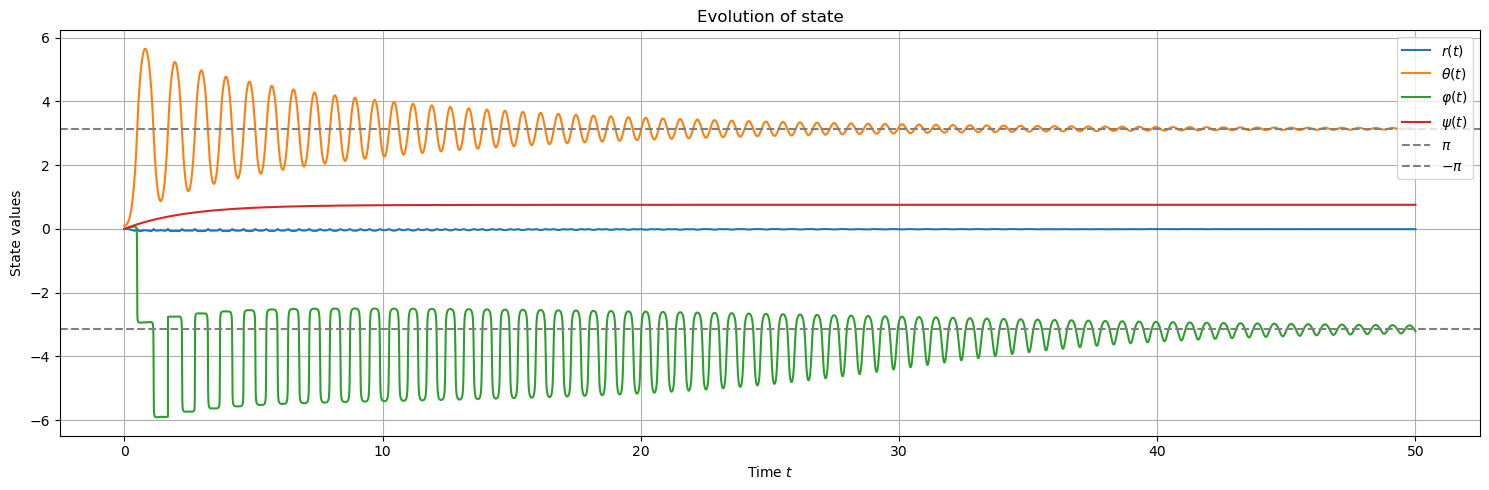

In [64]:
plt.figure(figsize=(15, 5))

plt.plot(sol.t, sol_r, label=r'$r(t)$')
plt.plot(sol.t, sol_theta, label=r'$\theta(t)$')
plt.plot(sol.t, sol_varphi, label=r'$\varphi(t)$')
plt.plot(sol.t, sol_psi, label=r'$\psi(t)$')

plt.axhline(y=np.pi, linestyle='--', color='gray', label=r'$\pi$')
plt.axhline(y=-np.pi, linestyle='--', color='gray', label=r'$-\pi$')


plt.xlabel('Time $t$')
plt.ylabel('State values')
plt.title('Evolution of state')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

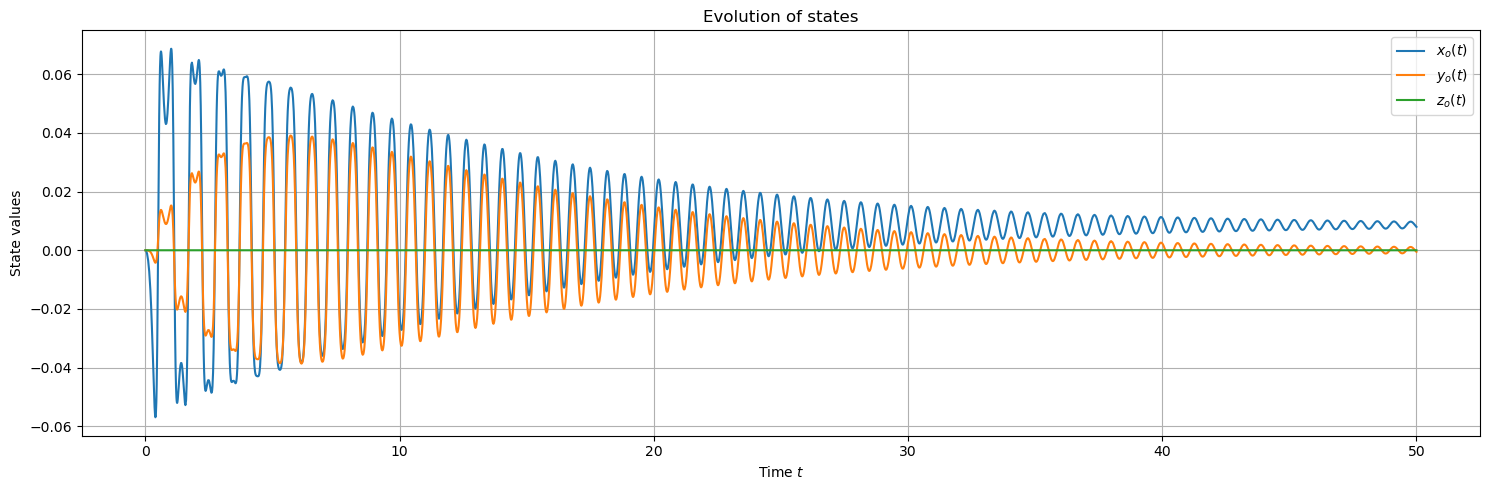

In [58]:
plt.figure(figsize=(15, 5))

plt.plot(sol.t, sol_xo, label=[r'$x_o(t)$', r'$y_o(t)$', r'$z_o(t)$'])

plt.xlabel('Time $t$')
plt.ylabel('State values')
plt.title('Evolution of states')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

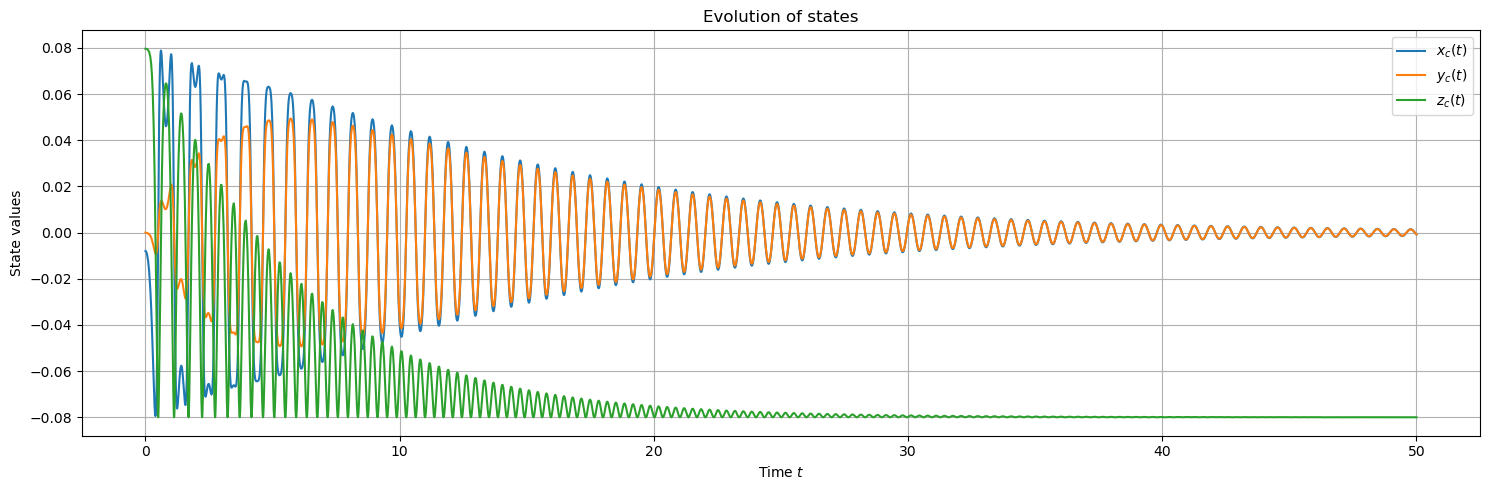

In [61]:
plt.figure(figsize=(15, 5))

plt.plot(sol.t, sol_x - sol_xo, label=[r'$x_c(t)$', r'$y_c(t)$', r'$z_c(t)$'])

plt.xlabel('Time $t$')
plt.ylabel('State values')
plt.title('Evolution of states')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

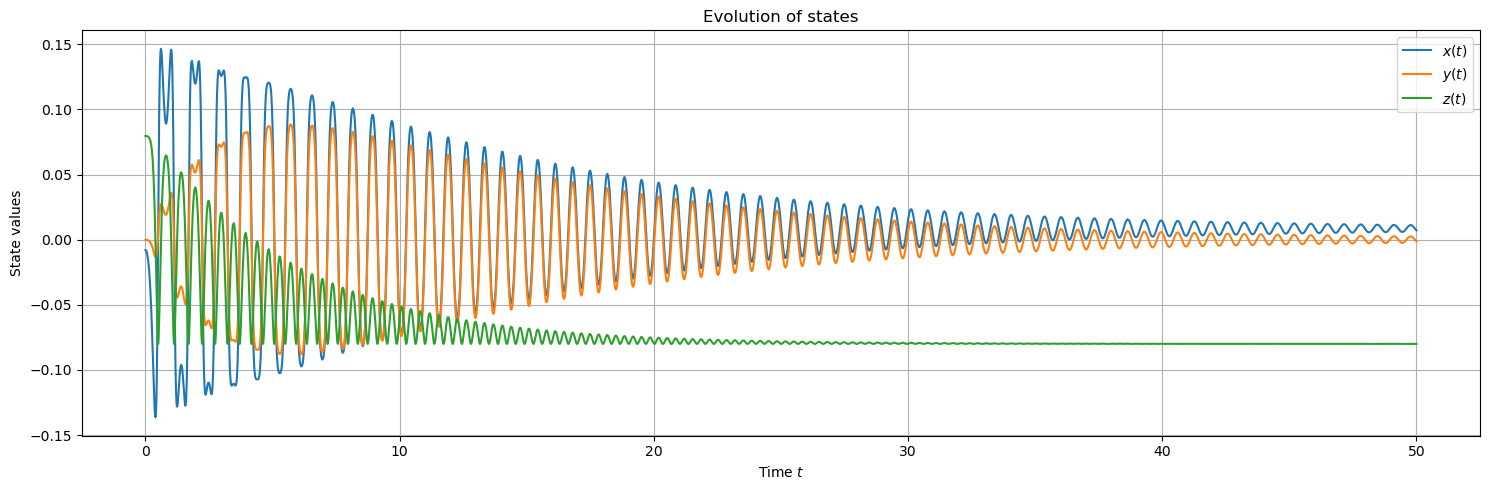

In [60]:
plt.figure(figsize=(15, 5))

plt.plot(sol.t, sol_x, label=[r'$x(t)$', r'$y(t)$', r'$z(t)$'])

plt.xlabel('Time $t$')
plt.ylabel('State values')
plt.title('Evolution of states')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()